In [1]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
!pip install sweetviz
import sweetviz as sv

Mounted at /content/drive
     |████████████████████████████████| 15.1MB 268kB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_err2.csv')
train_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_qui2.csv')
train_prob = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_prob2.csv')

test_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_err2.csv')
test_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_qui2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_qui2 = train_qui.copy()
test_qui2 = test_qui.copy()
train_err2 = train_err.copy()
test_err2 = test_err.copy()

# 퀼리티 3,4는 값이 1밖에 없어서 의미가 없기 때문에 제외
# 펌웨어 버전은 이미 err 자료에 있기 때문에 중복으로 제외
# 퀼리티 0은 EDA 결과 퀼리티 2와 피어슨 상관계수 0.99를 보이기 때문에 0과 2 중에 하나만 골랐음
# 0의 결측치 Nan은 15%고 2의 결측치는 4%기 때문에 결측치가 적은 2를 남기고 0은 drop 시킨다.

## 퀼리티 6과 7도 0.81로 강한 상관관계를 보이고 있는데, 하나를 제외해야 하나 고민이 됨
train_qui2.drop(['fwver','quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)
test_qui2.drop(['fwver', 'quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)

test_qui2 = test_qui2.replace(',','', regex=True)
train_qui2 = train_qui2.replace(',','', regex=True)
test_qui2.loc[:,'quality_1':'quality_12'] = test_qui2.loc[:,'quality_1':'quality_12'].astype(float)
train_qui2.loc[:,'quality_1':'quality_12'] = train_qui2.loc[:,'quality_1':'quality_12'].astype(float)

train_qui2['time'] = pd.to_datetime(train_qui['time'], format = '%Y-%m-%d %H:%M:%S')
test_qui2['time'] = pd.to_datetime(test_qui['time'], format = '%Y-%m-%d %H:%M:%S')

train_err2['time'] = pd.to_datetime(train_err2['time'], format = '%Y-%m-%d %H:%M:%S')
test_err2['time'] = pd.to_datetime(test_err2['time'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
# 퀼리티 임계치
# [-1, 0, 1] == -1 카테고리 -1, -1~0 =카테고리 0, 그 이상 = 카테고리 1
qualities = {}

qualities['quality_1'] = [-1,0, 1]
qualities['quality_2'] = [-1,0, 1]
qualities['quality_5'] = [-1,0,1,2,4, 10]
qualities['quality_6'] = [-1,0, 1]
qualities['quality_7'] = [0,1,100, 101]
qualities['quality_8'] = [0,1,2]
qualities['quality_9'] = [0,1,2]
qualities['quality_10'] = [0,1,2,3, 4, 5,7, 10 ,14,15] ##??
qualities['quality_11'] = [-1,0,1]
qualities['quality_12'] = [0,1,2]

## 모델 임계치
## 모델 0,1,2,3,4의 비율을 더하면 99.999% 이므로, 모델 5~8은 other model로 통합하는 것이 바람직 해 보임.

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

In [7]:
prob_list = list(set(train_prob.user_id))

In [10]:
def quality_categorize(dataset):
  data = dataset.copy()
  for key in tqdm(qualities):
    intervals = qualities.get(key)
    for i in range(len(intervals)):
      if intervals[i] == intervals[-1]:
        data[key][data[key] >= intervals[i]] =  intervals[i]
      # elif intervals[i+1] - intervals[i] == 1:
      #   continue
      else:
        data[key][(data[key] >= intervals[i]) & (data[key] < intervals[i+1])] = intervals[i]
  return data


In [11]:
train_qui3 = quality_categorize(train_qui2)
test_qui3 = quality_categorize(test_qui2)

In [12]:
train_qui3['problems'] = train_qui3.user_id.isin(prob_list)
train_qui3_tr = train_qui3[train_qui2['problems']]
train_qui3_fls = train_qui3[train_qui2['problems'] != True]

In [24]:
train_qui3_tr = train_qui3_tr[['user_id', 'quality_1', 'quality_2', 'quality_5', 'quality_6', 'quality_7', 'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12']] #, 'time']]
train_qui3_fls = train_qui3_fls[['user_id', 'quality_1', 'quality_2', 'quality_5', 'quality_6', 'quality_7', 'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12']] #, 'time']]

In [25]:
train_qui3_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387024 entries, 120 to 828623
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     387024 non-null  int64  
 1   quality_1   387024 non-null  float64
 2   quality_2   383163 non-null  float64
 3   quality_5   387006 non-null  float64
 4   quality_6   387024 non-null  float64
 5   quality_7   387024 non-null  float64
 6   quality_8   387024 non-null  float64
 7   quality_9   387024 non-null  float64
 8   quality_10  387024 non-null  float64
 9   quality_11  387024 non-null  float64
 10  quality_12  387024 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 35.4 MB


In [120]:
df = sv.compare([train_qui3_tr, "오류발생"], [train_qui3_fls, "정상"])
df.show_html("drive/My Drive/오류이용자_정상이용자_차이비교(퀼리티_data).html")


Report drive/My Drive/오류이용자_정상이용자_차이비교(퀼리티_data).html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [121]:
df

In [29]:
train_err3 = train_err2[['user_id', 'time']]

In [31]:
train_err3['problems'] = train_err3.user_id.isin(prob_list)

In [33]:
def cos_time(dataset):
  dataset['cos_time'] = np.cos(2*np.pi*dataset.hour/24)
  return dataset

In [36]:
train_err3['hour'] = train_err3.time.dt.hour

In [42]:
train_err4 = cos_time(train_err3)

In [40]:
ids = list(set(train_err4.user_id))

In [140]:
cos_stat = pd.DataFrame()

def cos_stats(data):
  cos_stat = []
  ids = list(set(data.user_id))
  ids.sort()
  for id in tqdm(ids):
    temp = data[data.user_id == id]
    means = temp['cos_time'].mean()
    if len(temp) > 1:
      stds = temp['cos_time'].std()
    else:
      stds = 0
    freq =  temp['cos_time'].mode().values[0]
    cos_stat.append([means,stds,freq])
  
  df = pd.DataFrame(cos_stat, columns = ['means', 'std', 'frq'], index = ids)
  return df

In [141]:
test = cos_stats(train_err4)

In [142]:
test2 = test.reset_index()

In [156]:
test_tr

,index,means,std,frq
1,10001,-0.131223,0.699130,0.707107
4,10004,0.161332,0.594964,0.707107
5,10005,0.281449,0.727768,0.707107
6,10006,-0.128289,0.697255,-0.866025
8,10008,0.508247,0.303569,0.500000
...,...,...,...,...
14983,24983,0.631239,0.419471,0.500000
14984,24984,0.057759,0.710383,0.866025
14990,24990,0.188986,0.667950,0.707107
14997,24997,0.163746,0.635167,0.707107


FloatingPointError: ignored

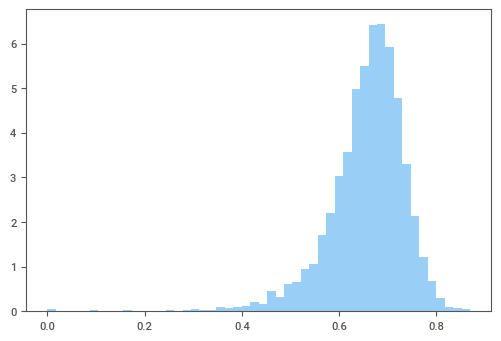

In [154]:
sns.distplot(test_tr['std'])

FloatingPointError: ignored

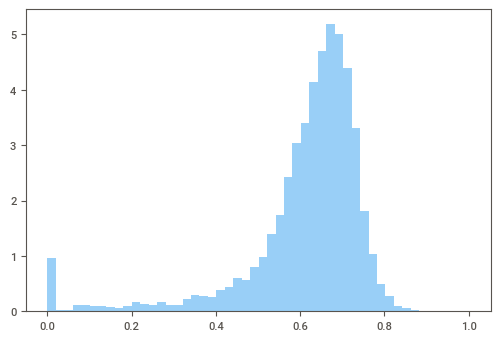

In [155]:
sns.distplot(test_fls['std'])

In [144]:
test2['problems'] = test2['index'].isin(prob_list)
test_tr = test2[test2['problems']]
test_fls = test2[test2['problems'] != True]

In [146]:
test_fls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     10000 non-null  int64  
 1   means     10000 non-null  float64
 2   std       10000 non-null  float64
 3   frq       10000 non-null  float64
 4   problems  10000 non-null  bool   
dtypes: bool(1), float64(3), int64(1)
memory usage: 400.4 KB


In [147]:
test_tr =test_tr[['index', 'means', 'std', 'frq']]
test_fls =test_fls[['index', 'means', 'std', 'frq']]

In [148]:
df2 = sv.compare([test_tr, "오류발생"], [test_fls, "정상"])

In [132]:
df

In [150]:
df2.show_html("drive/My Drive/오류.html")

ValueError: ignored

In [113]:
df.show_html("drive/My Drive/오류이용자_정상이용자_차이비교(시간대)_not_grouped.html")

ValueError: ignored

In [118]:
train_err3 = train_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]
test_err3 = test_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]

In [119]:
# 에러 코드의 분포는 다음과 같다.

print(train_err2.errcode.value_counts())
# 중간에 나오다가 잘리지만.. 전에 발간한 리포트를 보면 상위 15개 에러가 99.9%를 차지하고 있다.
# 따라서 상위 15개는 각각의 카테고리로 주고, 나머지는 16번째 '기타' 카테고리로 묶으면 어떨까 싶습니다.
# 상위 15개 리스트
err_code =['1','0','connection timeout','B-A8002','80','79','14','active','2','84','85','standby','NFANDROID2','connection fail to establish','3']

# 위의 15개에 포함되지 않는 에러코드는 걍 'etc'로 분류
train_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'
test_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'


## 에러타입은 어차피 41개 뿐이라... 분포도 고른 편 같고... 얌전히 두기로 함.

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
5867                        1
13130                       1
3787                        1
4357                        1
4978                        1
Name: errcode, Length: 2805, dtype: int64


In [ ]:
# 1일까지 발생한 오류 ~ 2일까지 발생한 오류 ~ 3일까지 ~~~ n일까지 발생한 오류(누적)을 0,1,2,3,4,5 칼럼에 넣어주는 함수
# 퀼리티 로그의 경우 문제가 생기면 문제 이후에 2시간 분량을 수집한다고 했으므로, 몇 번이나 수집되었는지 알면 문제가 몇 번 있었는지도 알 수 있다.
# time에 관한 EDA 결과, 에러코드 수집 시작시간 10월 31일 ~ 11월 30일까지

begins = date(2020, 10, 31).timetuple().tm_yday
ends = date(2020, 11, 30).timetuple().tm_yday

q_list = []
er_list = []

In [ ]:
###################### 시간 별 차이가 있는가...? ###################

In [ ]:
### 혹시나 몰라서 펌웨어 날려버리기 전에, 오류 사용자와 정상 사용자의 차이를 비교
# 정상 사용자가 많이 사용하는 모델과 오류 사용자가 많이 사용하는 모델에는 차이가 있는가.
# EDA 결과는 리포트로 구글 드라이브 메인에 저장.

temp =train_err2.drop_duplicates(subset = ['user_id'])
temp = temp[['user_id', 'model_nm', 'fwver']]

prob_list = list(set(train_prob.user_id))
temp['problems'] = temp.user_id.isin(prob_list)

temp_tr = temp[temp['problems']]
temp_fls = temp[temp['problems'] != True]

temp_tr.set_index('user_id', inplace = True)
temp_fls.set_index('user_id', inplace = True)

In [ ]:
train_err4 = train_err3.copy()

In [ ]:
train_err4['hour'] = train_err4['time'].dt.hour
train_err4['weekday'] = train_err4['time'].dt.weekday

In [ ]:
train_err4['problems'] = train_err4.user_id.isin(prob_list)
train_err4_tr = train_err4[train_err5['problems']]
train_err4_fls = train_err4[train_err5['problems'] != True]

In [ ]:
df = sv.compare([train_err4_tr, "오류발생"], [train_err4_fls, "정상"])
df.show_html("drive/My Drive/오류이용자_정상이용자_차이비교(시간대)_not_grouped2.html")

In [ ]:
train_err5 = train_err4[['user_id', 'hour', 'weekday']]

In [ ]:
def cos_time(dataset):
  dataset['cos_time'] = np.cos(2*np.pi*dataset.hour/24)
  return dataset

In [ ]:
train_err5 = cos_time(train_err5)

In [ ]:
train_err5

,user_id,hour,weekday,cos_time
0,10000,2,6,0.866025
1,10000,3,6,0.707107
2,10000,3,6,0.707107
3,10000,5,6,0.258819
4,10000,5,6,0.258819
...,...,...,...,...
16554658,24999,16,0,-0.500000
16554659,24999,17,0,-0.258819
16554660,24999,17,0,-0.258819
16554661,24999,17,0,-0.258819


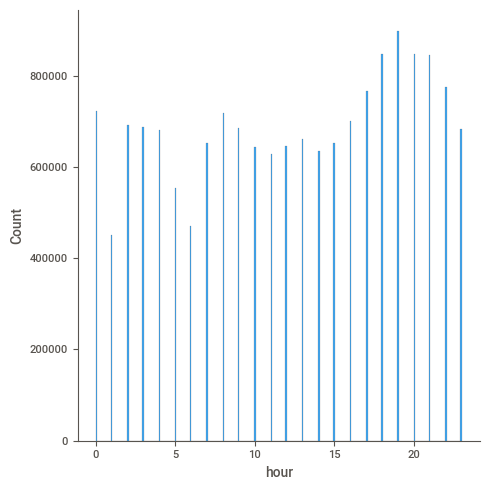

In [ ]:
sns.displot(train_err5.hour)

In [ ]:
train_err5['problems'] = train_err5.user_id.isin(prob_list)
train_err5_tr = train_err5[train_err5['problems']]
train_err5_fls = train_err5[train_err5['problems'] != True]

In [ ]:
df = sv.compare([train_err5_tr, "오류발생"], [train_err5_fls, "정상"])
df.show_html("drive/My Drive/오류이용자_정상이용자_차이비교(시간대)_not_grouped.html")


Report drive/My Drive/오류이용자_정상이용자_차이비교(시간대)_not_grouped.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
train6 = train_err5.groupby(by = 'user_id').mean()

In [ ]:
train6['problems'] = train6.user_id.isin(prob_list)

In [ ]:
train6_tr = train6[train6['problems']]
train6_fls = train6[train6['problems'] != True]

In [ ]:
train6_tr

,hour,weekday,cos_time,problems
user_id,,,,
10001,14.962791,3.553911,-0.131223,True
10004,13.296010,2.963964,0.161332,True
10005,13.060080,3.299065,0.281449,True
10006,11.067347,2.844898,-0.128289,True
10008,3.935484,3.112903,0.508247,True
...,...,...,...,...
24983,9.055718,2.744868,0.631239,True
24984,14.846777,3.106770,0.057759,True
24990,12.555862,3.477241,0.188986,True


In [ ]:
df = sv.compare([train6_tr, "오류발생"], [train6_fls, "정상"])
df.show_html("drive/My Drive/오류이용자_정상이용자_차이비교(시간대).html")


Report drive/My Drive/오류이용자_정상이용자_차이비교(시간대).html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# _err 자료에서 errcode를 정리한다.
# 가장 많이 나온 에러코드가 Most, 2번째가 Second

def errcode_sum(data):
    counts = []
    # ids = [10000,24999]
    ids = list(set(data.user_id.values))
    ids.sort()
    
    for id in tqdm(ids):
        err_list = []
        errs = data[data.user_id == id].errcode.value_counts()

        first = errs.index[0]
        try:
            second = errs.index[1]
        except:
            second = 'Nope'

        err_list.extend([first, second]) #, second, third])
        counts.append(err_list)
    frames = pd.DataFrame(counts, columns = ['Most_Err_Code', 'Second_Err_Code'], index = ids)
    return frames

In [ ]:
train_err_sum = errcode_sum(train_err3)
test_err_sum = errcode_sum(test_err3)

In [ ]:
train_err_sum.head(5)

,Most_Err_Code,Second_Err_Code
10000,1,0
10001,1,standby
10002,1,0
10003,1,0
10004,1,connection timeout


In [ ]:
# # _err 자료에서 각 id가 총 몇 번 보고 되었는지 카운트
id_error = train_err3[['user_id','errtype']].values
error = np.zeros((15000,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 10000,err - 1] += 1

ind = [i for i in range(10000,25000)]
train_err_type_count = pd.DataFrame(error, index = ind)

id_error = test_err3[['user_id','errtype']].values
error = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 30000,err - 1] += 1

ind = [i for i in range(30000,44999)]
test_err_type_count = pd.DataFrame(error, index = ind)

In [ ]:
test_err_type_count.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
30000,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,0.0,2.0
30001,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30002,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,1.0,2.0
30003,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,8.0,0.0
30004,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,90.0,0.0


In [ ]:
test_err_sum_by_day.to_csv("테스트_에러발생_일일누적합계.csv")
train_err_sum_by_day.to_csv("트레인_에러발생_일일누적합계.csv")

train_quality_sum.to_csv("트레인_퀼리티로그_일일수집합계.csv")
test_quality_sum.to_csv("테스트_퀼리티로그_일일수집합계.csv")

train_err_sum.to_csv("트레인_에러_에러코드별_발생횟수.csv")
test_err_sum.to_csv("테스트_에러_에러코드별_발생횟수.csv")

train_qui_frequent.to_csv("트레인_퀼리티_항목별_많이등장.csv")
test_qui_frequent.to_csv("테스트_퀼리티_항목별_많이등장.csv")

train_err_type_count.to_csv("트레인_에러_42항목별_카운트.csv")
test_err_type_count.to_csv("테스트_에러_42항목별_카운트.csv")

In [ ]:
!cp 테스트_에러발생_일일누적합계.csv "drive/My Drive/"
!cp 트레인_에러발생_일일누적합계.csv "drive/My Drive/"
!cp 트레인_퀼리티로그_일일수집합계.csv "drive/My Drive/"
!cp 테스트_퀼리티로그_일일수집합계.csv "drive/My Drive/"
!cp 트레인_에러_에러코드별_발생횟수.csv "drive/My Drive/"
!cp 테스트_에러_에러코드별_발생횟수.csv "drive/My Drive/"
!cp 트레인_퀼리티_항목별_많이등장.csv "drive/My Drive/"
!cp 테스트_퀼리티_항목별_많이등장.csv "drive/My Drive/"
!cp 트레인_에러_42항목별_카운트.csv "drive/My Drive/"
!cp 테스트_에러_42항목별_카운트.csv "drive/My Drive/"